# Section 9: Regularization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

## Dropout regularization

In [2]:
probability = .5
dropout = nn.Dropout(p=probability) 
X = torch.ones(10)
y = dropout(X)

print(X)
print(y)
print(torch.mean(y))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([2., 2., 2., 0., 0., 0., 2., 0., 2., 2.])
tensor(1.2000)


In [3]:
dropout.eval()

y = dropout(X)

print(X)
print(y)
print(torch.mean(y))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor(1.)


In [4]:
dropout.eval()

y = F.dropout(X)

print(X)
print(y)
print(torch.mean(y))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([0., 2., 2., 2., 0., 0., 0., 0., 0., 2.])
tensor(0.8000)


In [5]:
y = F.dropout(X, training=False)

print(X)
print(y)
print(torch.mean(y))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor(1.)


In [6]:
dropout.train()

y = dropout(X)

print(y)

dropout.eval()

y = dropout(X)

print(y)

y = dropout(X)

print(y)

tensor([0., 0., 0., 2., 0., 2., 0., 0., 2., 2.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


## Dropout regularization in practice

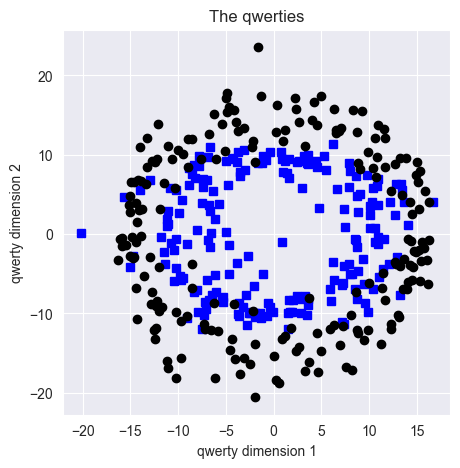

In [7]:
entities_per_cluster = 200
th = np.linspace(0, 4 * np.pi, entities_per_cluster)
r1 = 10
r2 = 15
a = [r1 * np.cos(th) + np.random.randn(entities_per_cluster) * 3, 
     r1 * np.sin(th) + np.random.randn(entities_per_cluster)]
b = [r2 * np.cos(th) + np.random.randn(entities_per_cluster), 
     r2 * np.sin(th) + np.random.randn(entities_per_cluster) * 3]
X_np = np.hstack((a, b)).T
y_np = np.vstack((np.zeros((entities_per_cluster, 1)), np.ones((entities_per_cluster, 1))))
X = torch.tensor(X_np).float()
y = torch.tensor(y_np).float()

plt.figure(figsize=(5, 5))
plt.plot(X[np.where(y==0)[0], 0], X[np.where(y==0)[0], 1], 'bs')
plt.plot(X[np.where(y==1)[0], 0], X[np.where(y==1)[0], 1], 'ko')
plt.title("The qwerties")
plt.xlabel("qwerty dimension 1")
plt.ylabel("qwerty dimension 2")
plt.show()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

X_y_train = TensorDataset(X_train, y_train)
X_y_test = TensorDataset(X_test, y_test)

batch_size = 16
train_loader = DataLoader(X_y_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(X_y_test, batch_size=X_y_test.tensors[0].shape[0])

In [9]:
class AnnQwerties(nn.Module):
     def __init__(self, dropout_rate_param):
          super().__init__()
          
          self.input = nn.Linear(2, 128)
          self.hidden = nn.Linear(128, 128)
          self.output = nn.Linear(128, 1)
          self.dropout = dropout_rate_param
          
     def forward(self, x):
          x = F.relu(self.input(x))
          x = F.dropout(x, p=self.dropout, training=self.training)
          x = F.relu(self.hidden(x))
          x = F.dropout(x, p=self.dropout, training=self.training)
          x = self.output(x)
          
          return x

In [10]:
test_net = AnnQwerties(.25)
test_X = torch.randn((10, 2))
test_y_pred = test_net(test_X)

test_y_pred

tensor([[-0.0578],
        [-0.0359],
        [-0.0645],
        [-0.1079],
        [-0.1400],
        [-0.0135],
        [ 0.0102],
        [-0.0755],
        [-0.0944],
        [ 0.2547]], grad_fn=<AddmmBackward0>)

In [11]:
def create_model(dropout_rate_param):
     ann_qwerties_local = AnnQwerties(dropout_rate_param)
     loss_fun_local = nn.BCEWithLogitsLoss()
     optimizer_local = torch.optim.SGD(ann_qwerties_local.parameters(), lr=.002)
     
     return ann_qwerties_local, loss_fun_local, optimizer_local

epochs = 500

def train_model(ann_qwerties_param, loss_fun_param, optimizer_param):
     train_accuracies_local = []
     test_accuracies_local = []
     
     for epoch in range(epochs):
          batch_accuracies = []
         
          ann_qwerties_param.train()
         
          for X_local, y_local in train_loader:
               y_pred = ann_qwerties_param(X_local)
               loss = loss_fun_param(y_pred, y_local)
               
               optimizer_param.zero_grad()
               loss.backward()
               optimizer_param.step()
             
               batch_accuracies.append(100 * torch.mean(((y_pred > .5) == y_local).float()).item())
             
          train_accuracies_local.append(np.mean(batch_accuracies))
    
          ann_qwerties_param.eval()
          
          X_local, y_local = next(iter(test_loader))
          y_pred = ann_qwerties_param(X_local)
          
          test_accuracies_local.append(100 * torch.mean(((y_pred > .5) == y_local).float()).item())
     
     return train_accuracies_local, test_accuracies_local

In [12]:
dropout_rate = .0
ann_qwerties, loss_fun, optimizer = create_model(dropout_rate)
train_accuracies, test_accuracies = train_model(ann_qwerties, loss_fun, optimizer)

In [13]:
def smooth(x, k=5):
     return np.convolve(x, np.ones(k) / k, mode='same')

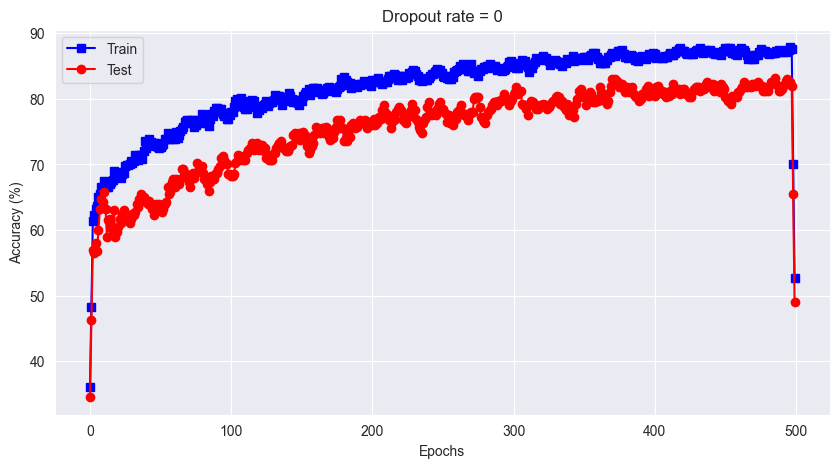

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(smooth(train_accuracies), 'bs-')
plt.plot(smooth(test_accuracies), 'ro-')
plt.xlabel('Epochs')
plt.ylabel("Accuracy (%)")
plt.legend(['Train', 'Test'])
plt.title("Dropout rate = %g" %dropout_rate)

plt.show()

In [15]:
dropout_rates = np.arange(10) / 10
results = np.zeros((len(dropout_rates), 2))

for i, dropout_rate in enumerate(dropout_rates):
     ann_qwerties, loss_fun, optimizer = create_model(dropout_rate)
     train_accuracies, test_accuracies = train_model(ann_qwerties, loss_fun, optimizer)
     
     results[i, 0] = np.mean(train_accuracies[-100:])
     results[i, 1] = np.mean(test_accuracies[-100:])

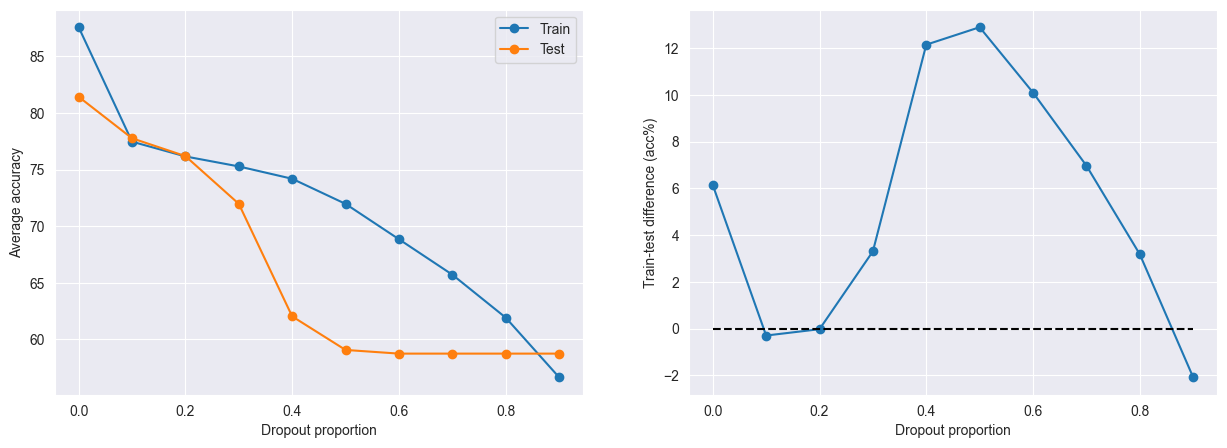

In [16]:
_, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(dropout_rates, results, 'o-')
ax[0].set_xlabel("Dropout proportion")
ax[0].set_ylabel("Average accuracy")
ax[0].legend(['Train', 'Test'])

ax[1].plot(dropout_rates, -np.diff(results, axis=1), 'o-')
ax[1].plot([0, .9], [0, 0], 'k--')
ax[1].set_xlabel("Dropout proportion")
ax[1].set_ylabel("Train-test difference (acc%)")

plt.show()

## Dropout example 2

In [17]:
iris = sns.load_dataset('iris')
X = torch.tensor(iris[iris.columns[0:4]].values).float()
y = torch.zeros(len(X), dtype=torch.long)
y[iris.species == 'versicolor'] = 1
y[iris.species == 'virginica'] = 2

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

X_y_train = TensorDataset(X_train, y_train)
X_y_test = TensorDataset(X_test, y_test)

batch_size = 16
train_loader = DataLoader(X_y_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(X_y_test, batch_size=X_y_test.tensors[0].shape[0])

In [19]:
class AnnIris(nn.Module):
     def __init__(self, dropout_rate_param):
          super().__init__()
          
          self.input = nn.Linear(4, 12)
          self.hidden = nn.Linear(12, 12)
          self.output = nn.Linear(12, 3)
          self.dropout = dropout_rate_param
          
     def forward(self, x):
          x = F.relu(self.input(x))
          x = F.dropout(x, p=self.dropout, training=self.training)
          x = F.relu(self.hidden(x))
          x = F.dropout(x, p=self.dropout, training=self.training)
          x = self.output(x)
          
          return x

In [20]:
test_net = AnnIris(.25)
test_X = torch.randn((10, 4))
test_y_pred = test_net(test_X)

test_y_pred

tensor([[ 0.3567, -0.3323,  0.0255],
        [ 0.2165, -0.1647,  0.1170],
        [ 0.1881, -0.2000,  0.0012],
        [ 0.1693, -0.1411,  0.1099],
        [ 0.0881, -0.0742,  0.0423],
        [ 0.0648, -0.1223,  0.0144],
        [ 0.2791, -0.2572, -0.2667],
        [ 0.0487, -0.0435, -0.0483],
        [ 0.0516, -0.1445,  0.0290],
        [ 0.3426, -0.3714,  0.0546]], grad_fn=<AddmmBackward0>)

In [21]:
def create_model(dropout_rate_param):
     ann_iris_local = AnnIris(dropout_rate_param)
     loss_fun_local = nn.CrossEntropyLoss()
     optimizer_local = torch.optim.SGD(ann_iris_local.parameters(), lr=.005)
     
     return ann_iris_local, loss_fun_local, optimizer_local

epochs = 500

def train_model(ann_iris_param, loss_fun_param, optimizer_param):
     train_accuracies_local = []
     test_accuracies_local = []
     
     for epoch in range(epochs):
          batch_accuracies = []
         
          ann_iris_param.train()
         
          for X_local, y_local in train_loader:
               y_pred = ann_iris_param(X_local)
               loss = loss_fun_param(y_pred, y_local)
               
               optimizer_param.zero_grad()
               loss.backward()
               optimizer_param.step()
             
               correct_predictions = (torch.argmax(y_pred, axis=1) == y_local).float()
             
               batch_accuracies.append(100 * torch.mean(correct_predictions).item())
             
          train_accuracies_local.append(np.mean(batch_accuracies))
    
          ann_iris_param.eval()
          
          X_local, y_local = next(iter(test_loader))
          y_pred = ann_iris_param(X_local)
          correct_predictions = (torch.argmax(y_pred, axis=1) == y_local).float()
          
          test_accuracies_local.append(100 * torch.mean(correct_predictions).item())
     
     return train_accuracies_local, test_accuracies_local

In [22]:
dropout_rate = .0
ann_iris, loss_fun, optimizer = create_model(dropout_rate)
train_accuracies, test_accuracies = train_model(ann_iris, loss_fun, optimizer)

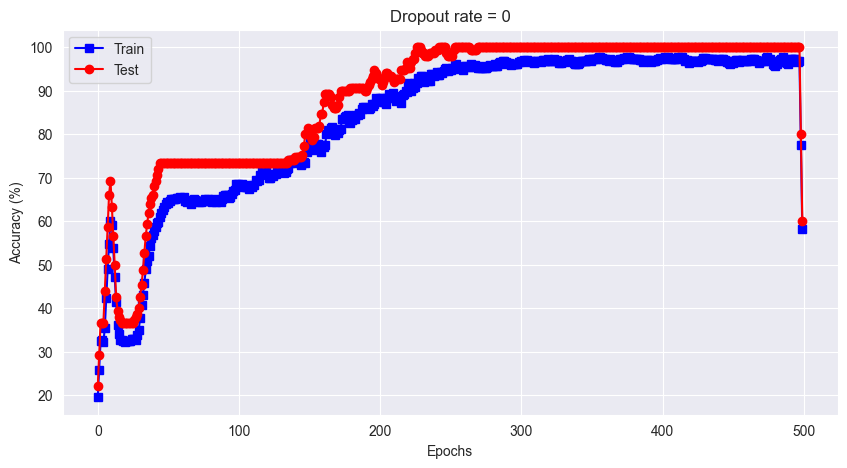

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(smooth(train_accuracies), 'bs-')
plt.plot(smooth(test_accuracies), 'ro-')
plt.xlabel('Epochs')
plt.ylabel("Accuracy (%)")
plt.legend(['Train', 'Test'])
plt.title("Dropout rate = %g" %dropout_rate)

plt.show()

In [24]:
dropout_rates = np.arange(10) / 10
results = np.zeros((len(dropout_rates), 2))

for i, dropout_rate in enumerate(dropout_rates):
     ann_iris, loss_fun, optimizer = create_model(dropout_rate)
     train_accuracies, test_accuracies = train_model(ann_iris, loss_fun, optimizer)
     
     results[i, 0] = np.mean(train_accuracies[-50:])
     results[i, 1] = np.mean(test_accuracies[-50:])

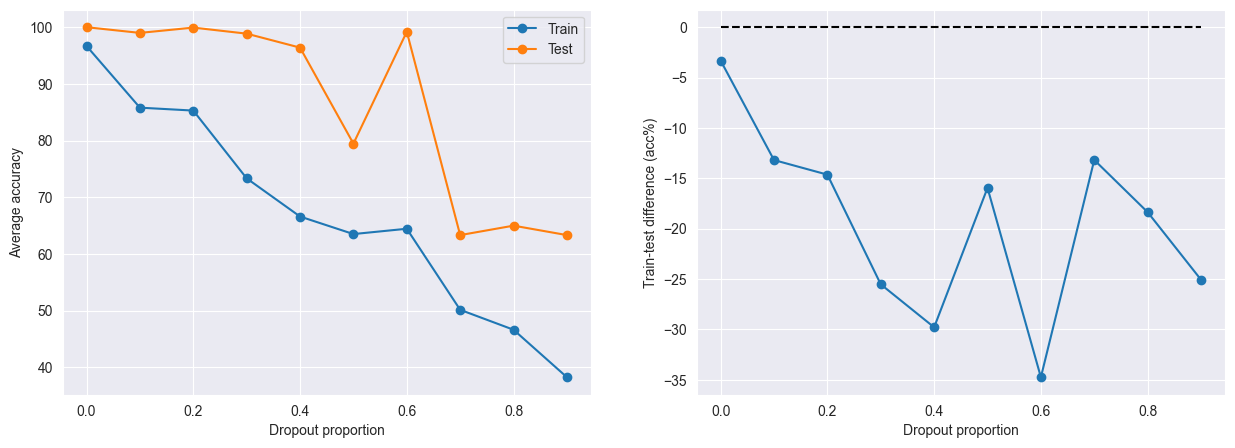

In [25]:
_, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(dropout_rates, results, 'o-')
ax[0].set_xlabel("Dropout proportion")
ax[0].set_ylabel("Average accuracy")
ax[0].legend(['Train', 'Test'])

ax[1].plot(dropout_rates, -np.diff(results, axis=1), 'o-')
ax[1].plot([0, .9], [0, 0], 'k--')
ax[1].set_xlabel("Dropout proportion")
ax[1].set_ylabel("Train-test difference (acc%)")

plt.show()

## L2 regularization in practice

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

X_y_train = TensorDataset(X_train, y_train)
X_y_test = TensorDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(X_y_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(X_y_test, batch_size=X_y_test.tensors[0].shape[0])

In [27]:
def create_model(l2_lambda_param):
     ann_iris_local = nn.Sequential(
          nn.Linear(4, 64),
          nn.ReLU(),
          nn.Linear(64, 64),
          nn.ReLU(),
          nn.Linear(64, 3),
     )
     loss_fun_local = nn.CrossEntropyLoss()
     optimizer_local = torch.optim.SGD(ann_iris_local.parameters(), lr=.005, weight_decay=l2_lambda_param)
     
     return ann_iris_local, loss_fun_local, optimizer_local

def train_model(ann_iris_param, loss_fun_param, optimizer_param):
     train_accuracies_local = []
     test_accuracies_local = []
     losses_local = []
     
     for epoch in range(epochs):
          batch_accuracies = []
          batch_losses = []
         
          ann_iris_param.train()
         
          for X_local, y_local in train_loader:
               y_pred = ann_iris_param(X_local)
               loss = loss_fun_param(y_pred, y_local)
               
               optimizer_param.zero_grad()
               loss.backward()
               optimizer_param.step()
             
               correct_predictions = (torch.argmax(y_pred, axis=1) == y_local).float()
             
               batch_accuracies.append(100 * torch.mean(correct_predictions).item())
               batch_losses.append(loss.item())
             
          train_accuracies_local.append(np.mean(batch_accuracies))
          losses_local.append(np.mean(batch_losses))
    
          ann_iris_param.eval()
          
          X_local, y_local = next(iter(test_loader))
          y_pred = ann_iris_param(X_local)
          correct_predictions = (torch.argmax(y_pred, axis=1) == y_local).float()
          
          test_accuracies_local.append(100 * torch.mean(correct_predictions).item())
     
     return train_accuracies_local, test_accuracies_local, losses_local

In [28]:
epochs = 1000
l2_lambda = .01
ann_iris, loss_fun, optimizer = create_model(l2_lambda)
train_accuracies, test_accuracies, losses = train_model(ann_iris, loss_fun, optimizer)

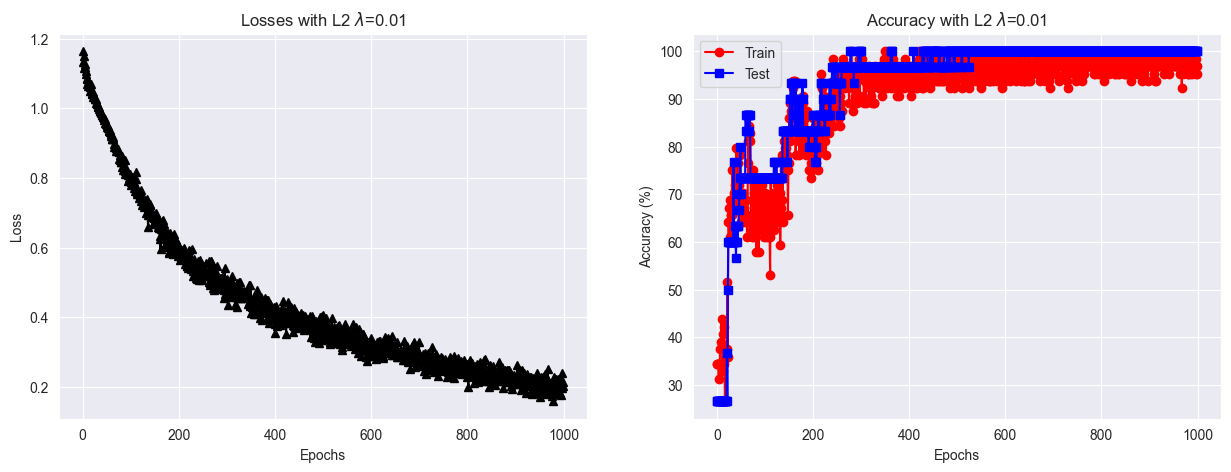

In [29]:
_, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(losses, 'k^-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title("Losses with L2 $\lambda$=" + str(l2_lambda))

ax[1].plot(train_accuracies, 'ro-')
ax[1].plot(test_accuracies, 'bs-')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title("Accuracy with L2 $\lambda$=" + str(l2_lambda))
ax[1].legend(['Train', 'Test'])

plt.show()

In [30]:
l2_lambdas = np.linspace(0, .1, 10)
train_accuracies_results = np.zeros((epochs, len(l2_lambdas)))
test_accuracies_results = np.zeros((epochs, len(l2_lambdas)))

for i, l2_lambda in enumerate(l2_lambdas):
     ann_iris, loss_fun, optimizer = create_model(l2_lambda)
     train_accuracies, test_accuracies, _ = train_model(ann_iris, loss_fun, optimizer)
     
     train_accuracies_results[:, i] = smooth(train_accuracies, 10)
     test_accuracies_results[:, i] = smooth(test_accuracies, 10)

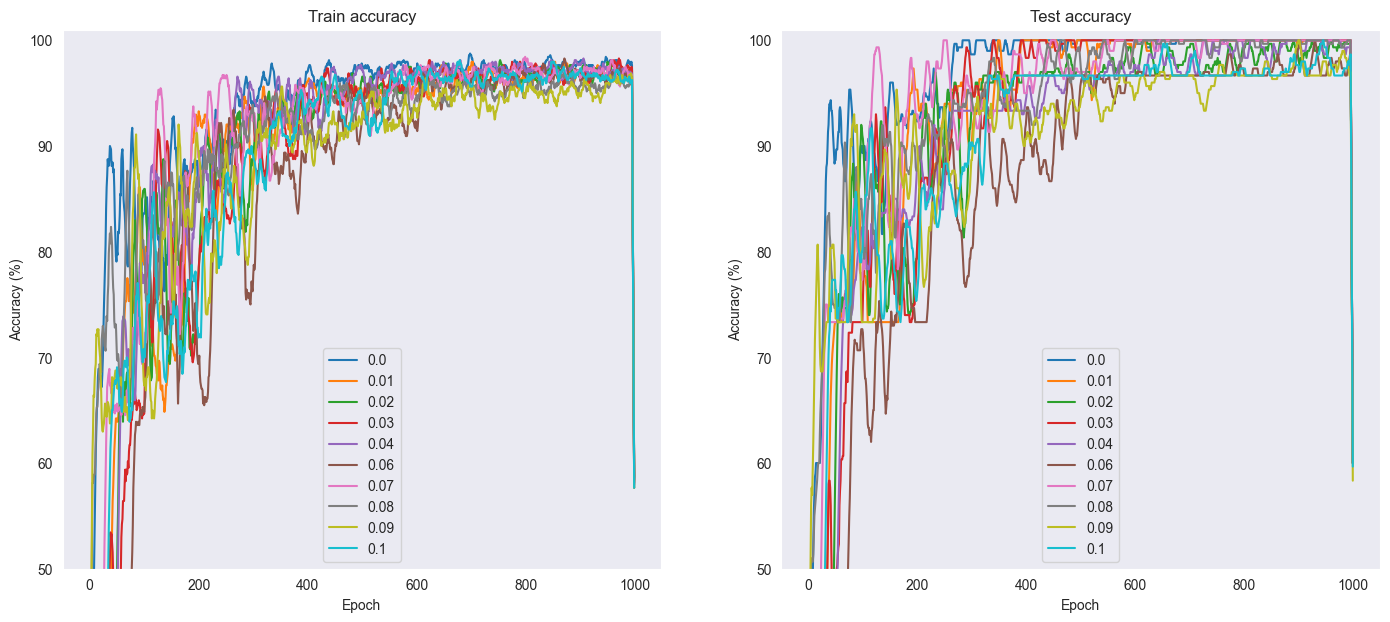

In [31]:
_, ax = plt.subplots(1, 2, figsize=(17, 7))

ax[0].plot(train_accuracies_results)
ax[0].set_title("Train accuracy")
ax[1].plot(test_accuracies_results)
ax[1].set_title("Test accuracy")

legend_labels = [np.round(i, 2) for i in l2_lambdas]

for i in range(2):
     ax[i].legend(legend_labels)
     ax[i].set_xlabel('Epoch')
     ax[i].set_ylabel("Accuracy (%)")
     ax[i].set_ylim([50, 101])
     ax[i].grid()
     
plt.show()

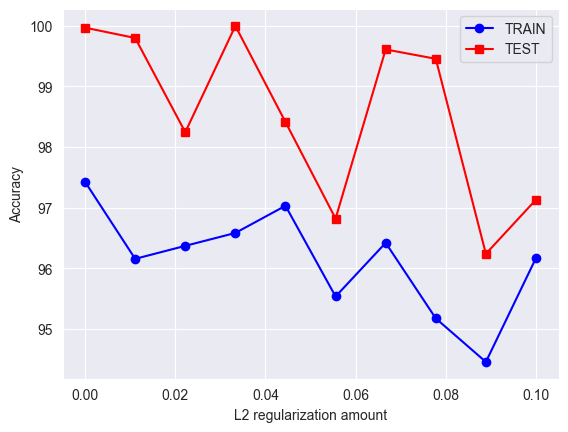

In [32]:
epoch_range = [500, 950]

plt.plot(
     l2_lambdas,
     np.mean(train_accuracies_results[epoch_range[0]:epoch_range[1], :], axis=0),
     'bo-',
     label='TRAIN'
)
plt.plot(
     l2_lambdas,
     np.mean(test_accuracies_results[epoch_range[0]:epoch_range[1], :], axis=0),
     'rs-',
     label='TEST'
)
plt.xlabel("L2 regularization amount")
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## L1 regularization in practice

In [33]:
def create_model():
     ann_iris_local = nn.Sequential(
          nn.Linear(4, 64),
          nn.ReLU(),
          nn.Linear(64, 64),
          nn.ReLU(),
          nn.Linear(64, 3),
     )
     loss_fun_local = nn.CrossEntropyLoss()
     optimizer_local = torch.optim.SGD(ann_iris_local.parameters(), lr=.005)
     
     return ann_iris_local, loss_fun_local, optimizer_local

In [34]:
temporary_model = create_model()[0]

print(temporary_model)

for i in temporary_model.named_parameters():
     print(i[0], i[1].shape, i[1].numel())

Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=3, bias=True)
)
0.weight torch.Size([64, 4]) 256
0.bias torch.Size([64]) 64
2.weight torch.Size([64, 64]) 4096
2.bias torch.Size([64]) 64
4.weight torch.Size([3, 64]) 192
4.bias torch.Size([3]) 3


In [35]:
def train_model(ann_iris_param, loss_fun_param, optimizer_param, l1_lambda_param):
     train_accuracies_local = []
     test_accuracies_local = []
     losses_local = []
     
     weights_nr = 0
     
     for parameters_name, weight in ann_iris_param.named_parameters():
          if 'bias' not in parameters_name:
               weights_nr += weight.numel()
     
     for epoch in range(epochs):
          batch_accuracies = []
          batch_losses = []
         
          ann_iris_param.train()
         
          for X_local, y_local in train_loader:
               y_pred = ann_iris_param(X_local)
               loss = loss_fun_param(y_pred, y_local)
               l1_term = torch.tensor(0., requires_grad=True)
               
               for parameters_name, weight in ann_iris_param.named_parameters():
                    if 'bias' not in parameters_name:
                         l1_term =  l1_term + torch.sum(torch.abs(weight))
               
               loss += l1_lambda_param * l1_term / weights_nr
               
               optimizer_param.zero_grad()
               loss.backward()
               optimizer_param.step()
             
               correct_predictions = (torch.argmax(y_pred, axis=1) == y_local).float()
             
               batch_accuracies.append(100 * torch.mean(correct_predictions).item())
               batch_losses.append(loss.item())
             
          train_accuracies_local.append(np.mean(batch_accuracies))
          losses_local.append(np.mean(batch_losses))
    
          ann_iris_param.eval()
          
          X_local, y_local = next(iter(test_loader))
          y_pred = ann_iris_param(X_local)
          correct_predictions = (torch.argmax(y_pred, axis=1) == y_local).float()
          
          test_accuracies_local.append(100 * torch.mean(correct_predictions).item())
     
     return train_accuracies_local, test_accuracies_local, losses_local

In [36]:
l1_lambda = .001
ann_iris, loss_fun, optimizer = create_model()
train_accuracies, test_accuracies, losses = train_model(ann_iris, loss_fun, optimizer, l1_lambda)

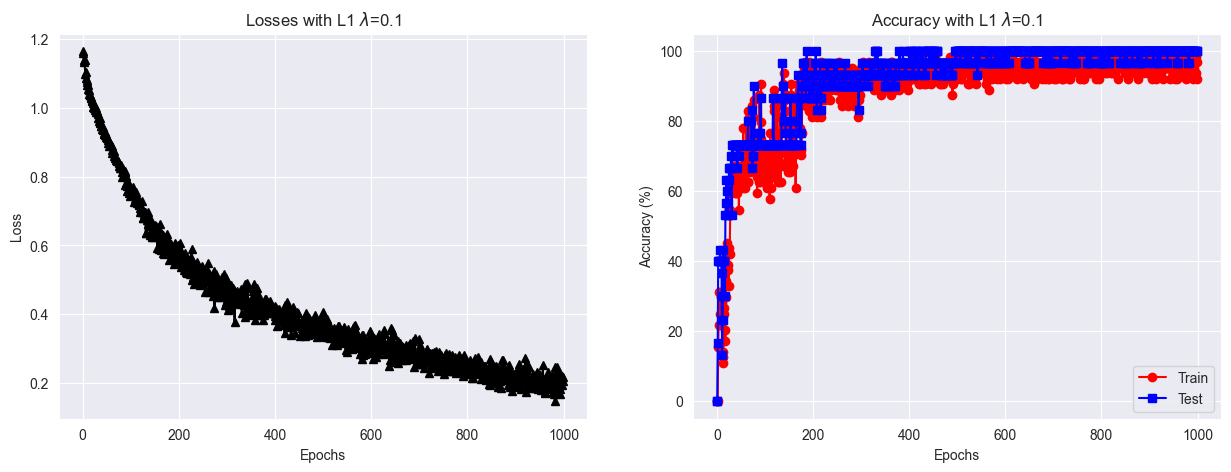

In [37]:
_, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(losses, 'k^-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title("Losses with L1 $\lambda$=" + str(l2_lambda))

ax[1].plot(train_accuracies, 'ro-')
ax[1].plot(test_accuracies, 'bs-')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title("Accuracy with L1 $\lambda$=" + str(l2_lambda))
ax[1].legend(['Train', 'Test'])

plt.show()

In [38]:
l1_lambdas = np.linspace(0, .005, 10)
train_accuracies_results = np.zeros((epochs, len(l1_lambdas)))
test_accuracies_results = np.zeros((epochs, len(l1_lambdas)))

for i, l1_lambda in enumerate(l1_lambdas):
     ann_iris, loss_fun, optimizer = create_model()
     train_accuracies, test_accuracies, losses = train_model(ann_iris, loss_fun, optimizer, l1_lambda)
     
     train_accuracies_results[:, i] = smooth(train_accuracies, 10)
     test_accuracies_results[:, i] = smooth(test_accuracies, 10)

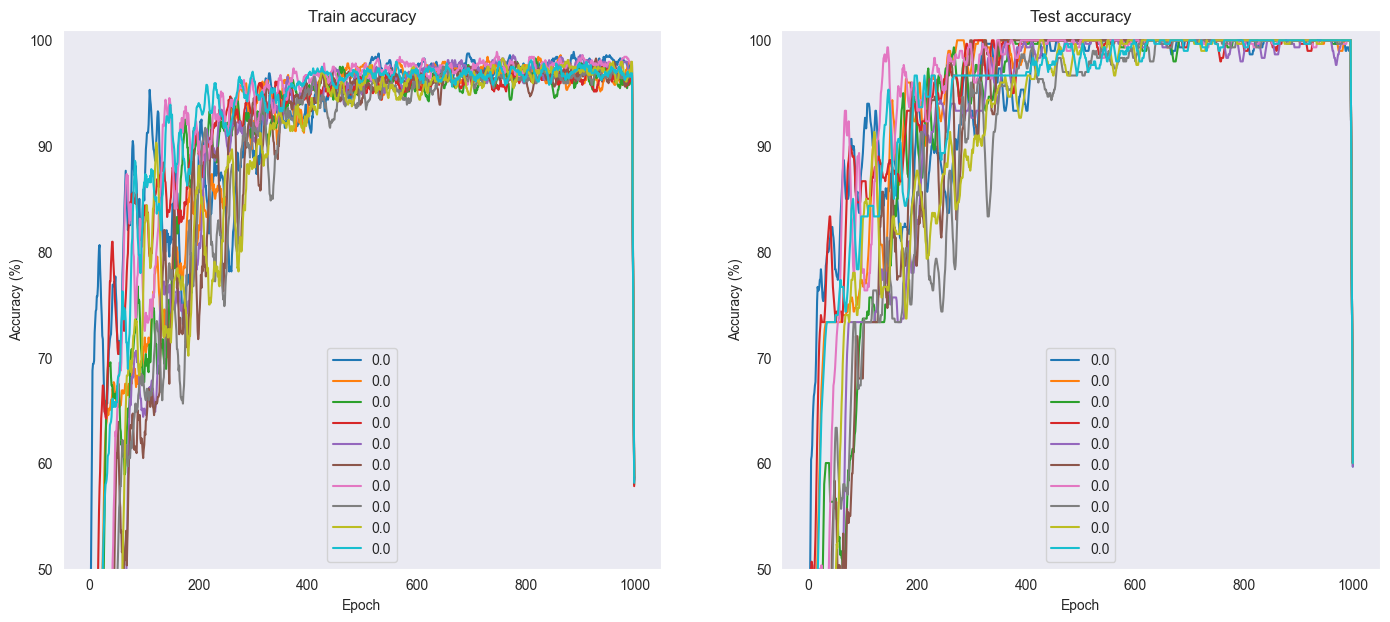

In [39]:
_, ax = plt.subplots(1, 2, figsize=(17, 7))

ax[0].plot(train_accuracies_results)
ax[0].set_title("Train accuracy")
ax[1].plot(test_accuracies_results)
ax[1].set_title("Test accuracy")

legend_labels = [np.round(i, 2) for i in l1_lambdas]

for i in range(2):
     ax[i].legend(legend_labels)
     ax[i].set_xlabel('Epoch')
     ax[i].set_ylabel("Accuracy (%)")
     ax[i].set_ylim([50, 101])
     ax[i].grid()
     
plt.show()

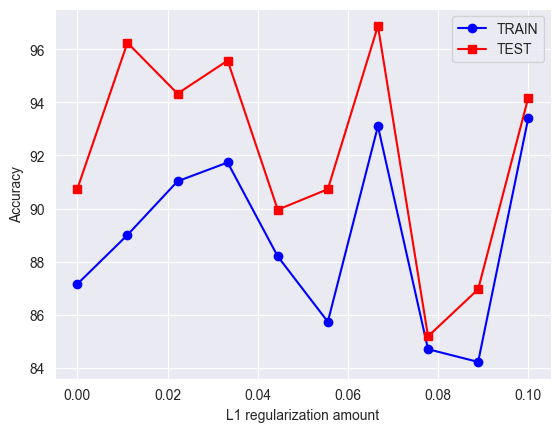

In [40]:
epoch_range = [160, 360]

plt.plot(
     l2_lambdas,
     np.mean(train_accuracies_results[epoch_range[0]:epoch_range[1], :], axis=0),
     'bo-',
     label='TRAIN'
)
plt.plot(
     l2_lambdas,
     np.mean(test_accuracies_results[epoch_range[0]:epoch_range[1], :], axis=0),
     'rs-',
     label='TEST'
)
plt.xlabel("L1 regularization amount")
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Batch training in action

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

X_y_train = TensorDataset(X_train, y_train)
X_y_test = TensorDataset(X_test, y_test)

batch_size = 16
train_loader = DataLoader(X_y_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(X_y_test, batch_size=X_y_test.tensors[0].shape[0])

In [42]:
for X_local, y_local in train_loader:
     print(X_local.shape, y_local.shape)

torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])


In [43]:
def create_model():
     ann_iris_local = nn.Sequential(
          nn.Linear(4, 64),
          nn.ReLU(),
          nn.Linear(64, 64),
          nn.ReLU(),
          nn.Linear(64, 3),
     )
     loss_fun_local = nn.CrossEntropyLoss()
     optimizer_local = torch.optim.SGD(ann_iris_local.parameters(), lr=.0005)
     
     return ann_iris_local, loss_fun_local, optimizer_local

def train_model(ann_iris_param, loss_fun_param, optimizer_param):
     train_accuracies_local = []
     test_accuracies_local = []
     losses_local = []
     
     for epoch in range(epochs):
          batch_accuracies = []
          batch_losses = []
         
          ann_iris_param.train()
         
          for X_local, y_local in train_loader:
               y_pred = ann_iris_param(X_local)
               loss = loss_fun_param(y_pred, y_local)
               
               optimizer_param.zero_grad()
               loss.backward()
               optimizer_param.step()
             
               correct_predictions = (torch.argmax(y_pred, axis=1) == y_local).float()
             
               batch_accuracies.append(100 * torch.mean(correct_predictions).item())
               batch_losses.append(loss.item())
             
          train_accuracies_local.append(np.mean(batch_accuracies))
          losses_local.append(np.mean(batch_losses))
    
          ann_iris_param.eval()
          
          X_local, y_local = next(iter(test_loader))
          y_pred = ann_iris_param(X_local)
          correct_predictions = (torch.argmax(y_pred, axis=1) == y_local).float()
          
          test_accuracies_local.append(100 * torch.mean(correct_predictions).item())
     
     return train_accuracies_local, test_accuracies_local, losses_local

In [44]:
ann_iris, loss_fun, optimizer = create_model()
train_accuracies, test_accuracies, losses = train_model(ann_iris, loss_fun, optimizer)

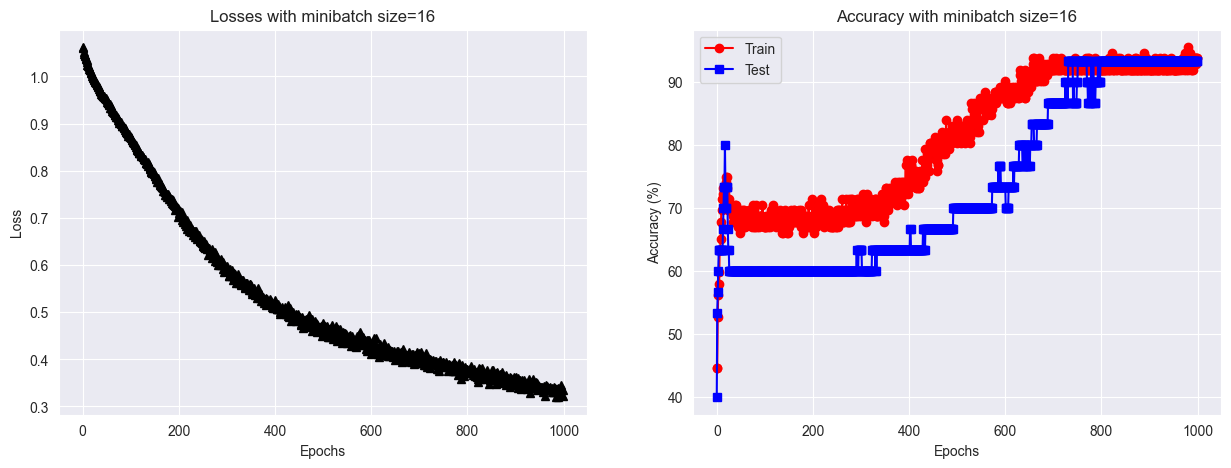

In [45]:
_, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(losses, 'k^-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title("Losses with minibatch size=" + str(batch_size))

ax[1].plot(train_accuracies, 'ro-')
ax[1].plot(test_accuracies, 'bs-')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title("Accuracy with minibatch size=" + str(batch_size))
ax[1].legend(['Train', 'Test'])

plt.show()

## The importance of equal batch sizes

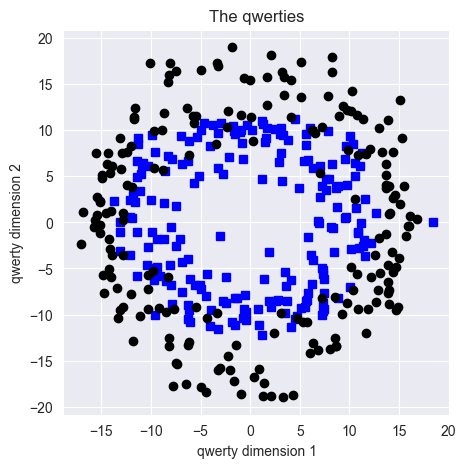

In [46]:
entities_per_cluster = 200
th = np.linspace(0, 4 * np.pi, entities_per_cluster)
r1 = 10
r2 = 15
a = [r1 * np.cos(th) + np.random.randn(entities_per_cluster) * 3, 
     r1 * np.sin(th) + np.random.randn(entities_per_cluster)]
b = [r2 * np.cos(th) + np.random.randn(entities_per_cluster), 
     r2 * np.sin(th) + np.random.randn(entities_per_cluster) * 3]
X_np = np.hstack((a, b)).T
y_np = np.vstack((np.zeros((entities_per_cluster, 1)), np.ones((entities_per_cluster, 1))))
X = torch.tensor(X_np).float()
y = torch.tensor(y_np).float()

plt.figure(figsize=(5, 5))
plt.plot(X[np.where(y==0)[0], 0], X[np.where(y==0)[0], 1], 'bs')
plt.plot(X[np.where(y==1)[0], 0], X[np.where(y==1)[0], 1], 'ko')
plt.title("The qwerties")
plt.xlabel("qwerty dimension 1")
plt.ylabel("qwerty dimension 2")
plt.show()

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1)

X_y_train = TensorDataset(X_train, y_train)
X_y_test = TensorDataset(X_test, y_test)

train_batch_size = 16
test_batch_size = X_y_test.tensors[0].shape[0] - 2
train_loader = DataLoader(X_y_train, batch_size=train_batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(X_y_test, batch_size=test_batch_size)

In [48]:
for X_local, y_local in test_loader:
     print(X_local.shape, y_local.shape)

torch.Size([38, 2]) torch.Size([38, 1])
torch.Size([2, 2]) torch.Size([2, 1])


In [49]:
class AnnQwerties(nn.Module):
     def __init__(self):
          super().__init__()
          
          self.input = nn.Linear(2, 128)
          self.hidden = nn.Linear(128, 128)
          self.output = nn.Linear(128, 1)
          
     def forward(self, x):
          x = F.relu(self.input(x))
          x = F.dropout(x)
          x = F.relu(self.hidden(x))
          x = F.dropout(x)
          x = self.output(x)
          
          return x

In [50]:
def create_model():
     ann_qwerties_local = AnnQwerties()
     loss_fun_local = nn.BCEWithLogitsLoss()
     optimizer_local = torch.optim.SGD(ann_qwerties_local.parameters(), lr=.01)
     
     return ann_qwerties_local, loss_fun_local, optimizer_local

epochs = 500

def train_model(ann_qwerties_param, loss_fun_param, optimizer_param):
     train_accuracies_local = []
     test_accuracies_local = []
     
     for epoch in range(epochs):
          train_accuracies_batch = []
          test_accuracies_batch = []
         
          ann_qwerties_param.train()
         
          for X_local, y_local in train_loader:
               y_pred = ann_qwerties_param(X_local)
               loss = loss_fun_param(y_pred, y_local)
               
               optimizer_param.zero_grad()
               loss.backward()
               optimizer_param.step()
             
               train_accuracies_batch.append(100 * torch.mean(((y_pred > 0) == y_local).float()).item())
             
          train_accuracies_local.append(np.mean(train_accuracies_batch))
    
          ann_qwerties_param.eval()
          
          for X_local, y_local in test_loader:
               y_pred = ann_qwerties_param(X_local)
              
               test_accuracies_batch.append(100 * torch.mean(((y_pred > .5) == y_local).float()).item())
          
          test_accuracies_local.append(np.mean(test_accuracies_batch))
     
     return train_accuracies_local, test_accuracies_local

In [51]:
ann_qwerties, loss_fun, optimizer = create_model()
train_accuracies, test_accuracies = train_model(ann_qwerties, loss_fun, optimizer)

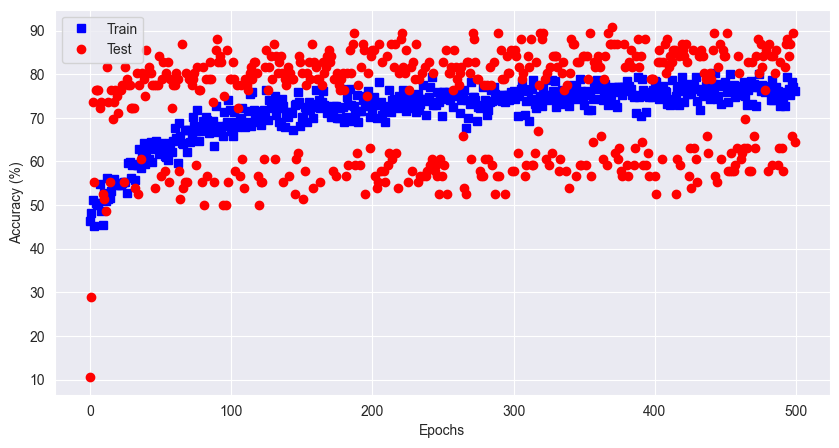

In [52]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, 'bs')
plt.plot(test_accuracies, 'ro')
plt.xlabel('Epochs')
plt.ylabel("Accuracy (%)")
plt.legend(['Train', 'Test'])
plt.show()

## CodeChallenge: Effects of mini-batch size

In [53]:
X = torch.tensor(iris[iris.columns[0:4]].values).float()
y = torch.zeros(len(X), dtype=torch.long)
y[iris.species == 'versicolor'] = 1
y[iris.species == 'virginica'] = 2

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

X_y_train = TensorDataset(X_train, y_train)
X_y_test = TensorDataset(X_test, y_test)

In [55]:
def create_model():
     ann_iris_local = nn.Sequential(
          nn.Linear(4, 64),
          nn.ReLU(),
          nn.Linear(64, 64),
          nn.ReLU(),
          nn.Linear(64, 3),
     )
     loss_fun_local = nn.CrossEntropyLoss()
     optimizer_local = torch.optim.SGD(ann_iris_local.parameters(), lr=.001)
     
     return ann_iris_local, loss_fun_local, optimizer_local

def train_model(ann_iris_param, loss_fun_param, optimizer_param):
     train_accuracies_local = []
     test_accuracies_local = []
     losses_local = []
     
     for epoch in range(epochs):
          batch_accuracies = []
          batch_losses = []
         
          ann_iris_param.train()
         
          for X_local, y_local in train_loader:
               y_pred = ann_iris_param(X_local)
               loss = loss_fun_param(y_pred, y_local)
               
               optimizer_param.zero_grad()
               loss.backward()
               optimizer_param.step()
             
               correct_predictions = (torch.argmax(y_pred, axis=1) == y_local).float()
             
               batch_accuracies.append(100 * torch.mean(correct_predictions).item())
               batch_losses.append(loss.item())
             
          train_accuracies_local.append(np.mean(batch_accuracies))
          losses_local.append(np.mean(batch_losses))
    
          ann_iris_param.eval()
          
          X_local, y_local = next(iter(test_loader))
          
          with torch.no_grad():
               y_pred = ann_iris_param(X_local)
          
          correct_predictions = (torch.argmax(y_pred, axis=1) == y_local).float()
          
          test_accuracies_local.append(100 * torch.mean(correct_predictions).item())
     
     return train_accuracies_local, test_accuracies_local, losses_local

In [56]:
batch_sizes = 2 ** np.arange(1, 7)
train_accuracies_results = np.zeros((epochs, len(batch_sizes)))
test_accuracies_results = np.zeros((epochs, len(batch_sizes)))
test_loader = DataLoader(X_y_test, batch_size=X_y_test.tensors[0].shape[0])

for i, batch_size in enumerate(batch_sizes):
     train_loader = DataLoader(X_y_train, batch_size=int(batch_size), shuffle=True, drop_last=True)
     ann_iris, loss_fun, optimizer = create_model()
     train_accuracies, test_accuracies, _ = train_model(ann_iris, loss_fun, optimizer)
     
     train_accuracies_results[:, i] = train_accuracies
     test_accuracies_results[:, i] = test_accuracies

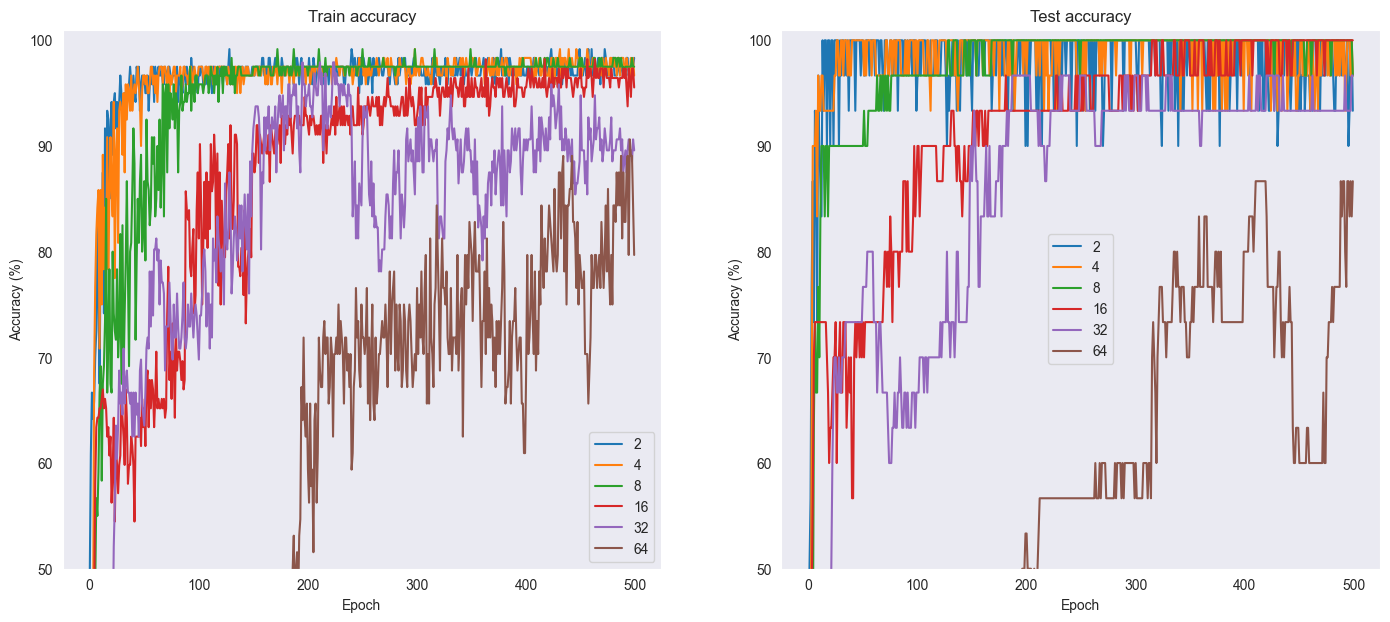

In [57]:
_, ax = plt.subplots(1, 2, figsize=(17, 7))

ax[0].plot(train_accuracies_results)
ax[0].set_title("Train accuracy")
ax[1].plot(test_accuracies_results)
ax[1].set_title("Test accuracy")

for i in range(2):
     ax[i].legend(batch_sizes)
     ax[i].set_xlabel('Epoch')
     ax[i].set_ylabel("Accuracy (%)")
     ax[i].set_ylim([50, 101])
     ax[i].grid()
     
plt.show()